<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_24_GridSearchCV_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !!DONE!! Ideally - no more changes here, there's a lot of meat to this one and I need to use it to generate results for report, can't afford to break it :) 

# WORDS OF CAUTION

I initially ran GridSearchCV on the whole X,y dataset (i.e. ignoring X_train/ y_train, X_test/ y_test) and spat out the best results without evaluation on unseen data. See...
* See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

i.e. With GridSearchCV, I need to..
* setup model
* fit with X_train/ y_train
* evaluate and find best model
* take best model and use X_test/ y_test on it





Also from...
* https://stackoverflow.com/a/55605798

"Internally, GridSearchCV splits the dataset given to it into various training and validation subsets, and, using the hyperparameter grid provided to it, finds the single set of hyperparameters that give the best score on the validation subsets.

The point of a train-test split is then, after this process is done, to perform one final scoring on the test data, which has so far been unknown to the model, to see if your hyperparameters have been overfit to the validation subsets. If it does well, then the next step is putting the model into production/deployment."

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [2]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [3]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 52
-rw------- 1 root root 29124 Nov 29 22:48 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [6]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
from scipy import stats

In [8]:
# install required libs
!pip install mido

     |████████████████████████████████| 61kB 7.0MB/s 


In [9]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-06 12:59:56.749691, module name: stats_n_features
>> LOADING custom module, when: 2020-12-06 12:59:56.750598, module name: data_prep
>> LOADING custom module, when: 2020-12-06 12:59:57.107070, module name: pipeline_utils


In [10]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-12-06 12:59:57.135892,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-06 12:59:57.136071,  param:hello


## Pandas display options

In [11]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [12]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

BULK LOAD: drummer1, drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
FILE name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid
    loaded file: <midi file '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid' type 0, 1 tracks, 1300 messages>
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=434783 time=0>
    track count: 1, tracks: [<midi track 'MIDI' 1300 messages>]
    MIDI file type: 0
    > processing track: <midi track 'MIDI' 1300 messages>
    __notes pre-filter: [36. 37. 38. 40. 43. 44. 51. 52. 53. 55.]
    __applying filter: [44]
    __notes post filter: [36. 37. 38. 40. 43. 51. 52. 53. 55.]
    note_on span - first tick: 3 , last tick: 30658 
    good instruments: 5, {36.0: 'Bass Drum 1 (36)', 38.0: 'Acoustic Snare (38)', 43.0: 'High Floor

''

## Single file tests..

In [13]:
##################################
######## EXPLORE SINGLE FILE

# experimenting on a single file here ...
key1 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid'
#key2 = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid'

test_data = all_drummer_data[key1]
df1 = test_data.tight_df.copy()
df1.head()

print('stats for: {}'.format(key1))
df1['beat_offset'].groupby(df1['note']).describe()
df1['velocity'].groupby(df1['note']).describe()


note  velocity  beat_offset  bar_beat_number
bar_number bar_beat_number                                              
1          1                  hh        55            7                1
           1                kick        64           10                1
           3                kick        57          -29                3
           3                  hh        31           -2                3
           5                  hh        54          -13                5

stats for: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,-4.674603,13.097071,-41.0,-12.00,-3.5,4.0,27.0
kick,54.0,-14.777778,15.486655,-54.0,-24.75,-13.0,-4.0,10.0
snare,79.0,-9.924051,20.791253,-58.0,-21.00,-8.0,0.5,55.0


,count,mean,std,min,25%,50%,75%,max
note,,,,,,,,
hh,126.0,50.436508,9.891003,30.0,44.0,49.0,56.00,83.0
kick,54.0,60.796296,15.543463,42.0,52.0,59.5,63.75,127.0
snare,79.0,71.506329,35.822523,8.0,33.0,90.0,102.00,117.0


In [14]:
# pull out notes in named bars...
display(df1.xs(1, level='bar_number')) 
display(df1.xs(2, level='bar_number')) 

,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,55,7,1
1,kick,64,10,1
3,kick,57,-29,3
3,hh,31,-2,3
5,hh,54,-13,5
5,snare,93,-5,5
7,hh,42,-16,7
8,snare,33,-12,8
10,snare,33,-14,10


,note,velocity,beat_offset,bar_beat_number
bar_beat_number,,,,
1,hh,42,-7,1
1,kick,55,-5,1
3,kick,62,-10,3
3,hh,41,3,3
5,snare,94,4,5
5,hh,51,5,5
7,hh,45,7,7
8,snare,32,7,8
9,hh,43,2,9


## Filter songs...

Take a look at all file names in the complete data set...

In [15]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

Code to pull out data to test, based on selected songs. Also add 'y' (target/ observation) label.

In [125]:

# FILTER SONGS BEING TESTED, ADD LABEL

def addLabelCol(df, label):
  '''
  Input: data_prep.PerformanceData.tight_df
  Return: df with additional colum for Y/ label called 'drummer_ID'
  '''
  df.insert(0, 'drummer_ID', label) # add it as first col
  return df

def load_songs(style_filter=[]):

  songs_data = []

  if len(style_filter) == 0:
    print('>>>> Loading all songs ...')
    for next_file in all_drummer_data.keys():
      perf_data = all_drummer_data[next_file]
      file_name = perf_data.file_wrapper.my_file_name
      print('  __{}'.format(file_name))
      df1 = perf_data.tight_df.copy()
      df2 = addLabelCol(df1, perf_data.drummer_id)  
      df2.reset_index(drop=True, inplace=True)
      songs_data.append(df2)
    print('>>>> DONE loading all songs.')
  else:
    for next_style in style_filter:
      print('>>>> Loading songs in style: {} ...'.format(next_style))

      # iterate through loaded files, extract songs
      # matching the any styles set in 'next_filter'
      for next_file in all_drummer_data.keys():
        perf_data = all_drummer_data[next_file]
        file_name = perf_data.file_wrapper.my_file_name
        if next_style in file_name:
          print('  __{}'.format(file_name))
          df1 = perf_data.tight_df.copy()
          df2 = addLabelCol(df1, perf_data.drummer_id)  
          df2.reset_index(drop=True, inplace=True)
          songs_data.append(df2)
        else:
          #print('  ... ignoring: {}'.format(file_name))
          pass
    print('>>>> DONE loading songs: {}'.format(style_filter))

  return songs_data

# specify style being processed
# 1_funk-groove1
# 3_soul-groove3
# 4_soul-groove4
# 6_hiphop-groove6
# 8_rock-groove8

#style_filter = "1_funk-groove1"  
#style_filter = "3_soul-groove3" 
#style_filter = "4_soul-groove4"
#style_filter = "6_hiphop-groove6"
#style_filter = "8_rock-groove8"

# empty list loads all data
#filtered_songs = load_songs(style_filter=[])
filtered_songs = load_songs(style_filter=["6_hiphop-groove6"])

# load ALL songs ...
#working_songs = load_songs()

# merge all into single df, drop indexes, reset default index
working_data = pd.concat(filtered_songs)
working_data.reset_index(inplace=True, drop=True)

# .. at this point, df 'working_data' is a collection
# of data for the same song, across all drummers, with
# DrummerID label

working_data.head(5)


>>>> Loading songs in style: 6_hiphop-groove6 ...
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer7/eval_session/6_hiphop-groove6_87_beat_4-4.mid
  __/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer8/eval_session/6_hiphop-groove6_87_beat_4-4.mid
>>>> DONE loading songs: ['6_hiphop-groove6']


,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,kick,127,0,1
1,drummer1,hh,58,9,1
2,drummer1,hh,17,-5,2
3,drummer1,hh,75,-1,3
4,drummer1,hh,16,-9,4


# Setup pipelines

In [126]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,0.132697,-0.163606
beat_offset,0.132697,1.000000,-0.026914
bar_beat_number,-0.163606,-0.026914,1.000000


## X, y split

Break into X, y before continuing ...

In [127]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [128]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number
0,kick,127,0,1
1,hh,58,9,1
2,hh,17,-5,2
3,hh,75,-1,3
4,hh,16,-9,4
5,kick,58,0,4
6,hh,60,2,5
7,snare,107,2,5
8,hh,21,0,6
9,hh,84,9,7


## Create transformers

In [20]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [21]:


t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity & offset

t_one_hot = OneHotEncoder(drop='first')    # instrument
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # velocity & offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # offset


# col indexes, 0-3: note, velocity, beat_offset, bar_beat_number

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 
# MinMax scaling of vel & offset, one hot for instrument & beat_pos
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0]),  # instrument
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling of vel & offset, one hot for instrument
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1]), # velocity 
               ('t_scaler_mm_2', t_scaler_mm_2, [2]),  # offset
               ('t_one_hot', t_one_hot, [0])]  # instrument
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, [1, 2]), ('t_one_hot', t_one_hot, [0])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)

# Std scaling of vel & offset, one hot for note and beat_pos.
t_v4_std = [('t_scaler_std', t_scaler_std, [1, 2]), # vel & offset
           ('t_one_hot', t_one_hot, [0]), # instrument, beat_pos
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, [3])]  # beat_pos 
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)


In [72]:
# new one to just encode 'note', leave everything else untouched
# i.e. no scaling or dummies needed, e.g. for DT
from sklearn.preprocessing import OrdinalEncoder
t_note_enc = [('t_label_enc', OrdinalEncoder(), [0])]
ct_note_enc = ColumnTransformer(transformers=t_note_enc, remainder='passthrough', sparse_threshold=0)


In [22]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [23]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 [0])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(), [1, 2]),
                                ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 [3])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [89]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)

In [90]:
output1.shape
pd.DataFrame(output1).head()

(812, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.560976,-8.620690e-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.569106,-8.620690e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.512195,-5.172414e-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.715447,-1.724138e-02,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.626016,-1.734723e-17,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
tmp_df.corr()


(812, 5)

,0,1,2,3,4
0,0.560976,-8.620690e-03,1.0,0.0,1.0
1,0.569106,-8.620690e-03,0.0,0.0,1.0
2,0.512195,-5.172414e-02,0.0,0.0,3.0
3,0.715447,-1.724138e-02,0.0,1.0,5.0
4,0.626016,-1.734723e-17,0.0,0.0,5.0


,0,1,2,3,4
0,1.000000,-0.084157,-0.369672,0.289012,0.143209
1,-0.084157,1.000000,0.017276,-0.087623,-0.067013
2,-0.369672,0.017276,1.000000,-0.204123,-0.299773
3,0.289012,-0.087623,-0.204123,1.000000,0.075212
4,0.143209,-0.067013,-0.299773,0.075212,1.000000


In [92]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
tmp_df.corr()

(812, 5)

,0,1,2,3,4
0,0.560976,0.491379,1.0,0.0,1.0
1,0.569106,0.491379,0.0,0.0,1.0
2,0.512195,0.448276,0.0,0.0,3.0
3,0.715447,0.482759,0.0,1.0,5.0
4,0.626016,0.500000,0.0,0.0,5.0


,0,1,2,3,4
0,1.000000,-0.084157,-0.369672,0.289012,0.143209
1,-0.084157,1.000000,0.017276,-0.087623,-0.067013
2,-0.369672,0.017276,1.000000,-0.204123,-0.299773
3,0.289012,-0.087623,-0.204123,1.000000,0.075212
4,0.143209,-0.067013,-0.299773,0.075212,1.000000


In [93]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
tmp_df.corr()

(812, 19)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.171554,0.316472,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.136642,0.316472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.381031,-0.142904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.491789,0.224596,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.107748,0.408347,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.000000,-0.084157,-0.369672,0.289012,-0.084485,-0.033320,0.008532,0.324429,-0.153931,-0.095444,0.039336,-0.291287,-0.288415,0.098676,0.015066,0.303122,-0.110012,0.117025,-0.037278
1,-0.084157,1.000000,0.017276,-0.087623,0.027244,-0.012836,-0.069166,0.065069,-0.187823,0.128794,0.079554,0.050160,0.053519,-0.067083,-0.034811,-0.113302,0.059096,-0.067171,-0.008980
2,-0.369672,0.017276,1.000000,-0.204123,-0.015120,-0.129127,-0.045585,-0.157665,-0.030296,-0.127014,-0.125949,0.679333,-0.125949,-0.131216,-0.026221,-0.157665,-0.021396,-0.127014,-0.094082
3,0.289012,-0.087623,-0.204123,1.000000,0.074072,-0.107475,-0.050188,0.457072,0.148418,-0.128116,-0.138668,-0.138668,-0.091437,-0.087416,-0.028868,0.457072,0.104818,-0.128116,-0.103582
4,-0.084485,0.027244,-0.015120,0.074072,1.000000,-0.010530,-0.003718,-0.012858,-0.002471,-0.010358,-0.010271,-0.010271,-0.010271,-0.010701,-0.002138,-0.012858,-0.001745,-0.010358,-0.007673
5,-0.033320,-0.012836,-0.129127,-0.107475,-0.010530,1.000000,-0.031748,-0.109809,-0.021100,-0.088462,-0.087720,-0.087720,-0.087720,-0.091388,-0.018262,-0.109809,-0.014902,-0.088462,-0.065525
6,0.008532,-0.069166,-0.045585,-0.050188,-0.003718,-0.031748,1.000000,-0.038765,-0.007449,-0.031229,-0.030967,-0.030967,-0.030967,-0.032262,-0.006447,-0.038765,-0.005261,-0.031229,-0.023132
7,0.324429,0.065069,-0.157665,0.457072,-0.012858,-0.109809,-0.038765,1.000000,-0.025763,-0.108013,-0.107107,-0.107107,-0.107107,-0.111586,-0.022298,-0.134078,-0.018195,-0.108013,-0.080007
8,-0.153931,-0.187823,-0.030296,0.148418,-0.002471,-0.021100,-0.007449,-0.025763,1.000000,-0.020755,-0.020581,-0.020581,-0.020581,-0.021441,-0.004285,-0.025763,-0.003496,-0.020755,-0.015374
9,-0.095444,0.128794,-0.127014,-0.128116,-0.010358,-0.088462,-0.031229,-0.108013,-0.020755,1.000000,-0.086285,-0.086285,-0.086285,-0.089893,-0.017963,-0.108013,-0.014658,-0.087015,-0.064453


## Train/ test split...

In [129]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)


In [130]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number
750,kick,51,-8,15
167,hh,43,7,8
1159,snare,127,1,13


In [131]:
X_train.describe()
X_test.describe()

,velocity,beat_offset,bar_beat_number
count,976.000000,976.000000,976.000000
mean,68.715164,-6.444672,8.689549
std,34.981502,14.840451,4.393577
min,5.000000,-57.000000,1.000000
25%,39.000000,-16.000000,5.000000
50%,63.000000,-6.000000,9.000000
75%,95.000000,4.000000,13.000000
max,127.000000,56.000000,16.000000


,velocity,beat_offset,bar_beat_number
count,245.000000,245.000000,245.000000
mean,69.571429,-4.885714,8.448980
std,33.563129,14.796267,4.559539
min,5.000000,-43.000000,1.000000
25%,43.000000,-15.000000,5.000000
50%,67.000000,-4.000000,8.000000
75%,92.000000,5.000000,13.000000
max,127.000000,59.000000,16.000000


## Some pipelines

In [32]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])


# Test pipelines

## Util functions


In [33]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [132]:
print('fitting the pipeline ...')
pipe_v3.fit(X_train, y_train)

print('predicting ...')
predictions_1 = pipe_v3.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.7551020408163265

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.70      0.76      0.73        78
    drummer5       0.78      0.78      0.78        45
    drummer7       0.83      0.77      0.80        64
    drummer8       0.74      0.72      0.73        58

    accuracy                           0.76       245
   macro avg       0.76      0.76      0.76       245
weighted avg       0.76      0.76      0.76       245


Confusion matrix...


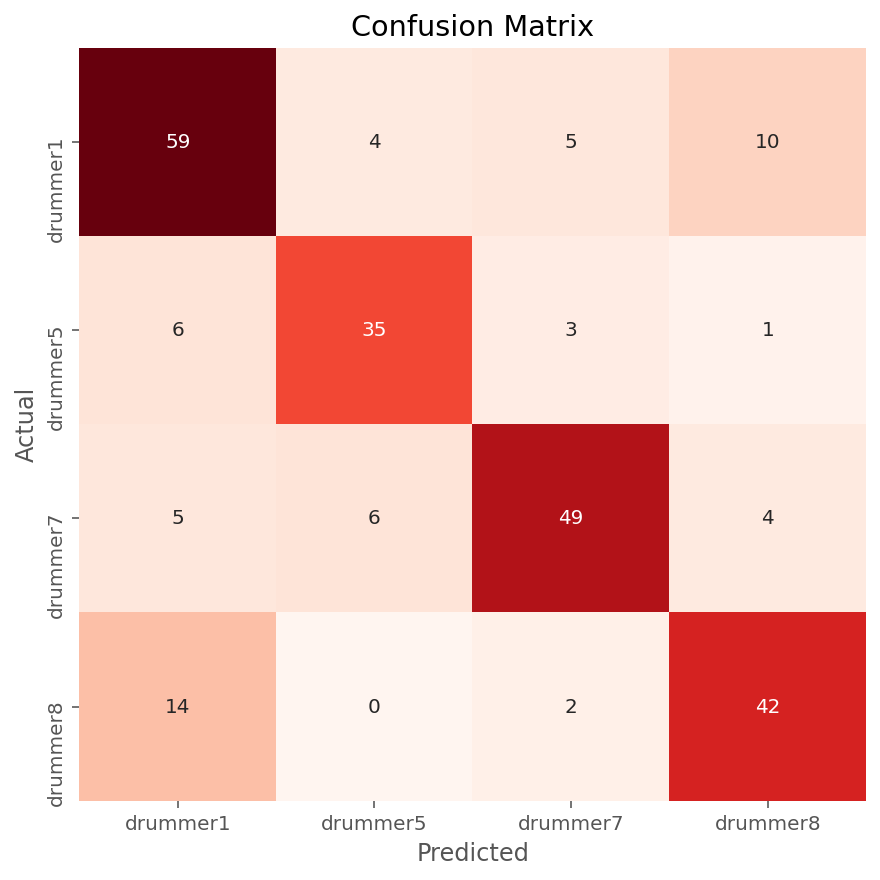

In [133]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# DummyClassifier
See...
* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier

In [134]:
from sklearn.dummy import DummyClassifier

# uniform, stratified, most_frequent, prior, constant
clf = DummyClassifier(strategy='stratified', random_state=0)
clf.fit(X_train, y_train)

print('clf score: {}'.format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

DummyClassifier(random_state=0, strategy='stratified')

clf score: 0.2897959183673469
              precision    recall  f1-score   support

    drummer1       0.37      0.29      0.32        84
    drummer5       0.19      0.20      0.19        45
    drummer7       0.27      0.34      0.30        59
    drummer8       0.31      0.32      0.31        57

    accuracy                           0.29       245
   macro avg       0.28      0.29      0.28       245
weighted avg       0.30      0.29      0.29       245



# K-fold CV, manual loop thru pipes

Compares..
* k=1-20
* 4 different pre-processing pipes

::TODO:: try different cv values.

In [135]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]


results = []
best_score = 0
best_info = ''
best_pipe = None
best_k = 0

kf = KFold(n_splits=10, shuffle=True, random_state=27)

for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
      best_pipe = next_pipe
      best_k = next_k
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.7377551020408163


array([0.67346939, 0.74489796, 0.67346939, 0.74489796, 0.81632653,
       0.7244898 , 0.7628866 , 0.72164948, 0.73195876, 0.78350515])



 ___ pipe #0, k=2, mean:0.697853986955607


array([0.67346939, 0.66326531, 0.68367347, 0.65306122, 0.75510204,
       0.65306122, 0.75257732, 0.72164948, 0.65979381, 0.7628866 ])



 ___ pipe #0, k=3, mean:0.7254260467073428


array([0.73469388, 0.70408163, 0.66326531, 0.74489796, 0.78571429,
       0.70408163, 0.71134021, 0.72164948, 0.67010309, 0.81443299])



 ___ pipe #0, k=4, mean:0.7203240058910163


array([0.7244898 , 0.71428571, 0.67346939, 0.74489796, 0.74489796,
       0.68367347, 0.74226804, 0.72164948, 0.65979381, 0.79381443])



 ___ pipe #0, k=5, mean:0.717210183042289


array([0.7244898 , 0.68367347, 0.68367347, 0.73469388, 0.74489796,
       0.73469388, 0.7628866 , 0.72164948, 0.63917526, 0.74226804])



 ___ pipe #0, k=6, mean:0.7018304228908059


array([0.67346939, 0.7244898 , 0.68367347, 0.73469388, 0.71428571,
       0.69387755, 0.73195876, 0.69072165, 0.6185567 , 0.75257732])



 ___ pipe #0, k=7, mean:0.6936145592257522


array([0.67346939, 0.68367347, 0.69387755, 0.73469388, 0.7244898 ,
       0.68367347, 0.72164948, 0.63917526, 0.62886598, 0.75257732])



 ___ pipe #0, k=8, mean:0.6731432779297285


array([0.62244898, 0.64285714, 0.65306122, 0.73469388, 0.73469388,
       0.66326531, 0.70103093, 0.6185567 , 0.60824742, 0.75257732])



 ___ pipe #0, k=9, mean:0.668083315800547


array([0.59183673, 0.66326531, 0.60204082, 0.74489796, 0.69387755,
       0.66326531, 0.71134021, 0.6185567 , 0.6185567 , 0.77319588])



 ___ pipe #0, k=10, mean:0.6454870608037029


array([0.59183673, 0.64285714, 0.6122449 , 0.7244898 , 0.67346939,
       0.63265306, 0.71134021, 0.58762887, 0.59793814, 0.68041237])



 ___ pipe #0, k=11, mean:0.629076372817168


array([0.59183673, 0.59183673, 0.62244898, 0.71428571, 0.65306122,
       0.62244898, 0.62886598, 0.56701031, 0.59793814, 0.70103093])



 ___ pipe #0, k=12, mean:0.6105512308015989


array([0.6122449 , 0.60204082, 0.6122449 , 0.69387755, 0.63265306,
       0.6122449 , 0.59793814, 0.53608247, 0.58762887, 0.6185567 ])



 ___ pipe #0, k=13, mean:0.5932253313696612


array([0.56122449, 0.6122449 , 0.57142857, 0.66326531, 0.57142857,
       0.59183673, 0.6185567 , 0.5257732 , 0.55670103, 0.65979381])



 ___ pipe #0, k=14, mean:0.5830212497370082


array([0.53061224, 0.59183673, 0.56122449, 0.64285714, 0.56122449,
       0.58163265, 0.63917526, 0.51546392, 0.58762887, 0.6185567 ])



 ___ pipe #0, k=15, mean:0.5768882810856301


array([0.52040816, 0.58163265, 0.54081633, 0.63265306, 0.58163265,
       0.56122449, 0.62886598, 0.51546392, 0.56701031, 0.63917526])



 ___ pipe #0, k=16, mean:0.5748474647590994


array([0.51020408, 0.58163265, 0.57142857, 0.58163265, 0.59183673,
       0.56122449, 0.60824742, 0.53608247, 0.58762887, 0.6185567 ])



 ___ pipe #0, k=17, mean:0.56463286345466


array([0.52040816, 0.55102041, 0.54081633, 0.56122449, 0.58163265,
       0.55102041, 0.58762887, 0.53608247, 0.58762887, 0.62886598])



 ___ pipe #0, k=18, mean:0.5543656637912896


array([0.5       , 0.58163265, 0.51020408, 0.53061224, 0.57142857,
       0.57142857, 0.57731959, 0.51546392, 0.58762887, 0.59793814])



 ___ pipe #0, k=19, mean:0.5369766463286345


array([0.44897959, 0.53061224, 0.53061224, 0.5       , 0.53061224,
       0.59183673, 0.58762887, 0.51546392, 0.55670103, 0.57731959])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.7490742688828108


array([0.69387755, 0.76530612, 0.71428571, 0.73469388, 0.79591837,
       0.69387755, 0.79381443, 0.74226804, 0.74226804, 0.81443299])



 ___ pipe #1, k=2, mean:0.7173048600883651


array([0.7244898 , 0.74489796, 0.67346939, 0.69387755, 0.7244898 ,
       0.65306122, 0.7628866 , 0.74226804, 0.74226804, 0.71134021])



 ___ pipe #1, k=3, mean:0.751051967178624


array([0.75510204, 0.7755102 , 0.7244898 , 0.73469388, 0.79591837,
       0.69387755, 0.82474227, 0.73195876, 0.73195876, 0.74226804])



 ___ pipe #1, k=4, mean:0.7377340626972438


array([0.73469388, 0.78571429, 0.69387755, 0.75510204, 0.76530612,
       0.66326531, 0.80412371, 0.74226804, 0.70103093, 0.73195876])



 ___ pipe #1, k=5, mean:0.7387965495476541


array([0.7244898 , 0.75510204, 0.70408163, 0.74489796, 0.76530612,
       0.67346939, 0.79381443, 0.72164948, 0.72164948, 0.78350515])



 ___ pipe #1, k=6, mean:0.7377971807279613


array([0.7244898 , 0.76530612, 0.67346939, 0.74489796, 0.76530612,
       0.66326531, 0.84536082, 0.71134021, 0.71134021, 0.77319588])



 ___ pipe #1, k=7, mean:0.7295918367346939


array([0.75510204, 0.73469388, 0.66326531, 0.75510204, 0.75510204,
       0.63265306, 0.77319588, 0.75257732, 0.70103093, 0.77319588])



 ___ pipe #1, k=8, mean:0.7213864927414264


array([0.70408163, 0.75510204, 0.66326531, 0.74489796, 0.7244898 ,
       0.66326531, 0.79381443, 0.71134021, 0.71134021, 0.74226804])



 ___ pipe #1, k=9, mean:0.6998001262360616


array([0.70408163, 0.7244898 , 0.65306122, 0.74489796, 0.71428571,
       0.65306122, 0.73195876, 0.65979381, 0.69072165, 0.72164948])



 ___ pipe #1, k=10, mean:0.6731643172733011


array([0.66326531, 0.71428571, 0.66326531, 0.70408163, 0.67346939,
       0.6122449 , 0.71134021, 0.6185567 , 0.68041237, 0.69072165])



 ___ pipe #1, k=11, mean:0.6577845571218178


array([0.64285714, 0.70408163, 0.64285714, 0.71428571, 0.64285714,
       0.60204082, 0.64948454, 0.58762887, 0.67010309, 0.72164948])



 ___ pipe #1, k=12, mean:0.6403324216284452


array([0.6122449 , 0.71428571, 0.6122449 , 0.69387755, 0.66326531,
       0.58163265, 0.65979381, 0.58762887, 0.60824742, 0.67010309])



 ___ pipe #1, k=13, mean:0.6270355564906376


array([0.57142857, 0.69387755, 0.59183673, 0.65306122, 0.67346939,
       0.59183673, 0.64948454, 0.60824742, 0.57731959, 0.65979381])



 ___ pipe #1, k=14, mean:0.616810435514412


array([0.55102041, 0.66326531, 0.59183673, 0.66326531, 0.64285714,
       0.58163265, 0.64948454, 0.58762887, 0.56701031, 0.67010309])



 ___ pipe #1, k=15, mean:0.5850515463917525


array([0.55102041, 0.63265306, 0.59183673, 0.56122449, 0.59183673,
       0.57142857, 0.58762887, 0.56701031, 0.54639175, 0.64948454])



 ___ pipe #1, k=16, mean:0.5584472964443509


array([0.5       , 0.66326531, 0.52040816, 0.53061224, 0.55102041,
       0.54081633, 0.60824742, 0.50515464, 0.56701031, 0.59793814])



 ___ pipe #1, k=17, mean:0.5308647170208289


array([0.42857143, 0.58163265, 0.5       , 0.51020408, 0.54081633,
       0.5       , 0.60824742, 0.48453608, 0.55670103, 0.59793814])



 ___ pipe #1, k=18, mean:0.5175678518830212


array([0.39795918, 0.58163265, 0.46938776, 0.47959184, 0.52040816,
       0.51020408, 0.60824742, 0.50515464, 0.5257732 , 0.57731959])



 ___ pipe #1, k=19, mean:0.5062802440563854


array([0.40816327, 0.57142857, 0.47959184, 0.45918367, 0.46938776,
       0.52040816, 0.59793814, 0.48453608, 0.5257732 , 0.54639175])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.7439406690511257


array([0.69387755, 0.76530612, 0.71428571, 0.7244898 , 0.79591837,
       0.68367347, 0.79381443, 0.74226804, 0.72164948, 0.80412371])



 ___ pipe #2, k=2, mean:0.7214180517567852


array([0.7244898 , 0.75510204, 0.67346939, 0.70408163, 0.7244898 ,
       0.64285714, 0.7628866 , 0.74226804, 0.73195876, 0.75257732])



 ___ pipe #2, k=3, mean:0.7551546391752577


array([0.76530612, 0.78571429, 0.7244898 , 0.74489796, 0.79591837,
       0.68367347, 0.82474227, 0.74226804, 0.72164948, 0.7628866 ])



 ___ pipe #2, k=4, mean:0.7387544708605092


array([0.74489796, 0.7755102 , 0.70408163, 0.76530612, 0.76530612,
       0.65306122, 0.80412371, 0.75257732, 0.69072165, 0.73195876])



 ___ pipe #2, k=5, mean:0.7398169577109195


array([0.73469388, 0.74489796, 0.70408163, 0.74489796, 0.76530612,
       0.68367347, 0.79381443, 0.72164948, 0.72164948, 0.78350515])



 ___ pipe #2, k=6, mean:0.7408584052177571


array([0.7244898 , 0.78571429, 0.67346939, 0.74489796, 0.76530612,
       0.67346939, 0.83505155, 0.72164948, 0.71134021, 0.77319588])



 ___ pipe #2, k=7, mean:0.7316326530612245


array([0.75510204, 0.73469388, 0.66326531, 0.75510204, 0.76530612,
       0.64285714, 0.77319588, 0.75257732, 0.70103093, 0.77319588])



 ___ pipe #2, k=8, mean:0.7234378287397434


array([0.70408163, 0.75510204, 0.66326531, 0.74489796, 0.7244898 ,
       0.67346939, 0.79381443, 0.72164948, 0.71134021, 0.74226804])



 ___ pipe #2, k=9, mean:0.7018514622343783


array([0.70408163, 0.7244898 , 0.65306122, 0.74489796, 0.71428571,
       0.66326531, 0.74226804, 0.65979381, 0.69072165, 0.72164948])



 ___ pipe #2, k=10, mean:0.6731643172733011


array([0.66326531, 0.71428571, 0.66326531, 0.70408163, 0.67346939,
       0.6122449 , 0.71134021, 0.62886598, 0.67010309, 0.69072165])



 ___ pipe #2, k=11, mean:0.6567536292867663


array([0.64285714, 0.70408163, 0.64285714, 0.71428571, 0.64285714,
       0.60204082, 0.64948454, 0.59793814, 0.64948454, 0.72164948])



 ___ pipe #2, k=12, mean:0.640321901956659


array([0.62244898, 0.71428571, 0.6122449 , 0.69387755, 0.66326531,
       0.58163265, 0.64948454, 0.59793814, 0.59793814, 0.67010309])



 ___ pipe #2, k=13, mean:0.6270355564906376


array([0.57142857, 0.69387755, 0.59183673, 0.65306122, 0.67346939,
       0.59183673, 0.65979381, 0.60824742, 0.56701031, 0.65979381])



 ___ pipe #2, k=14, mean:0.6167999158426257


array([0.55102041, 0.66326531, 0.59183673, 0.66326531, 0.65306122,
       0.58163265, 0.63917526, 0.58762887, 0.55670103, 0.68041237])



 ___ pipe #2, k=15, mean:0.5870818430464969


array([0.56122449, 0.63265306, 0.59183673, 0.56122449, 0.60204082,
       0.58163265, 0.58762887, 0.56701031, 0.53608247, 0.64948454])



 ___ pipe #2, k=16, mean:0.5584472964443509


array([0.5       , 0.66326531, 0.52040816, 0.53061224, 0.55102041,
       0.54081633, 0.60824742, 0.50515464, 0.55670103, 0.60824742])



 ___ pipe #2, k=17, mean:0.5308541973490427


array([0.42857143, 0.59183673, 0.5       , 0.51020408, 0.54081633,
       0.5       , 0.60824742, 0.48453608, 0.54639175, 0.59793814])



 ___ pipe #2, k=18, mean:0.5155059962129181


array([0.39795918, 0.58163265, 0.46938776, 0.47959184, 0.52040816,
       0.51020408, 0.60824742, 0.49484536, 0.51546392, 0.57731959])



 ___ pipe #2, k=19, mean:0.5011466442247002


array([0.40816327, 0.57142857, 0.47959184, 0.45918367, 0.46938776,
       0.5       , 0.59793814, 0.48453608, 0.50515464, 0.53608247])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.7439406690511257


array([0.69387755, 0.76530612, 0.71428571, 0.7244898 , 0.79591837,
       0.68367347, 0.79381443, 0.74226804, 0.72164948, 0.80412371])



 ___ pipe #3, k=2, mean:0.7214180517567852


array([0.7244898 , 0.75510204, 0.67346939, 0.70408163, 0.7244898 ,
       0.64285714, 0.7628866 , 0.74226804, 0.73195876, 0.75257732])



 ___ pipe #3, k=3, mean:0.7551546391752577


array([0.76530612, 0.78571429, 0.7244898 , 0.74489796, 0.79591837,
       0.68367347, 0.82474227, 0.74226804, 0.72164948, 0.7628866 ])



 ___ pipe #3, k=4, mean:0.7387544708605092


array([0.74489796, 0.7755102 , 0.70408163, 0.76530612, 0.76530612,
       0.65306122, 0.80412371, 0.75257732, 0.69072165, 0.73195876])



 ___ pipe #3, k=5, mean:0.7408373658741848


array([0.73469388, 0.75510204, 0.70408163, 0.74489796, 0.76530612,
       0.68367347, 0.79381443, 0.72164948, 0.72164948, 0.78350515])



 ___ pipe #3, k=6, mean:0.7408584052177571


array([0.7244898 , 0.78571429, 0.67346939, 0.74489796, 0.76530612,
       0.67346939, 0.83505155, 0.72164948, 0.71134021, 0.77319588])



 ___ pipe #3, k=7, mean:0.7316326530612245


array([0.75510204, 0.73469388, 0.66326531, 0.75510204, 0.76530612,
       0.64285714, 0.77319588, 0.75257732, 0.70103093, 0.77319588])



 ___ pipe #3, k=8, mean:0.7234378287397434


array([0.70408163, 0.75510204, 0.66326531, 0.74489796, 0.7244898 ,
       0.67346939, 0.79381443, 0.72164948, 0.71134021, 0.74226804])



 ___ pipe #3, k=9, mean:0.7018514622343783


array([0.70408163, 0.7244898 , 0.65306122, 0.74489796, 0.71428571,
       0.66326531, 0.74226804, 0.65979381, 0.69072165, 0.72164948])



 ___ pipe #3, k=10, mean:0.6731643172733011


array([0.66326531, 0.71428571, 0.66326531, 0.70408163, 0.67346939,
       0.6122449 , 0.71134021, 0.62886598, 0.67010309, 0.69072165])



 ___ pipe #3, k=11, mean:0.6567536292867663


array([0.64285714, 0.70408163, 0.64285714, 0.71428571, 0.64285714,
       0.60204082, 0.64948454, 0.59793814, 0.64948454, 0.72164948])



 ___ pipe #3, k=12, mean:0.640321901956659


array([0.62244898, 0.71428571, 0.6122449 , 0.69387755, 0.66326531,
       0.58163265, 0.64948454, 0.59793814, 0.59793814, 0.67010309])



 ___ pipe #3, k=13, mean:0.6270355564906376


array([0.57142857, 0.69387755, 0.59183673, 0.65306122, 0.67346939,
       0.59183673, 0.65979381, 0.60824742, 0.56701031, 0.65979381])



 ___ pipe #3, k=14, mean:0.6157795076793604


array([0.55102041, 0.66326531, 0.59183673, 0.66326531, 0.64285714,
       0.58163265, 0.63917526, 0.58762887, 0.55670103, 0.68041237])



 ___ pipe #3, k=15, mean:0.5850410267199663


array([0.56122449, 0.63265306, 0.59183673, 0.56122449, 0.59183673,
       0.57142857, 0.58762887, 0.56701031, 0.53608247, 0.64948454])



 ___ pipe #3, k=16, mean:0.5584472964443509


array([0.5       , 0.66326531, 0.52040816, 0.53061224, 0.55102041,
       0.54081633, 0.60824742, 0.50515464, 0.55670103, 0.60824742])



 ___ pipe #3, k=17, mean:0.5308541973490427


array([0.42857143, 0.59183673, 0.5       , 0.51020408, 0.54081633,
       0.5       , 0.60824742, 0.48453608, 0.54639175, 0.59793814])



 ___ pipe #3, k=18, mean:0.5165369240479697


array([0.39795918, 0.58163265, 0.46938776, 0.47959184, 0.52040816,
       0.51020408, 0.60824742, 0.50515464, 0.51546392, 0.57731959])



 ___ pipe #3, k=19, mean:0.5011466442247002


array([0.40816327, 0.57142857, 0.47959184, 0.45918367, 0.46938776,
       0.5       , 0.59793814, 0.48453608, 0.50515464, 0.53608247])


_______________________________________________________

>>>> pipe #4.. 



 ___ pipe #4, k=1, mean:0.7449715968861771


array([0.68367347, 0.73469388, 0.68367347, 0.73469388, 0.80612245,
       0.73469388, 0.7628866 , 0.74226804, 0.74226804, 0.82474227])



 ___ pipe #4, k=2, mean:0.7060382916053018


array([0.66326531, 0.70408163, 0.70408163, 0.65306122, 0.75510204,
       0.66326531, 0.7628866 , 0.73195876, 0.70103093, 0.72164948])



 ___ pipe #4, k=3, mean:0.7366926151904061


array([0.7244898 , 0.75510204, 0.67346939, 0.75510204, 0.79591837,
       0.70408163, 0.73195876, 0.72164948, 0.69072165, 0.81443299])



 ___ pipe #4, k=4, mean:0.7305280875236692


array([0.71428571, 0.7755102 , 0.68367347, 0.73469388, 0.78571429,
       0.69387755, 0.73195876, 0.68041237, 0.69072165, 0.81443299])



 ___ pipe #4, k=5, mean:0.7366715758468336


array([0.7244898 , 0.75510204, 0.67346939, 0.74489796, 0.78571429,
       0.74489796, 0.80412371, 0.71134021, 0.64948454, 0.77319588])



 ___ pipe #4, k=6, mean:0.7090363980643805


array([0.68367347, 0.74489796, 0.67346939, 0.73469388, 0.73469388,
       0.66326531, 0.7628866 , 0.68041237, 0.67010309, 0.74226804])



 ___ pipe #4, k=7, mean:0.7222911845150431


array([0.69387755, 0.73469388, 0.70408163, 0.79591837, 0.7755102 ,
       0.67346939, 0.73195876, 0.68041237, 0.64948454, 0.78350515])



 ___ pipe #4, k=8, mean:0.7099936881969283


array([0.69387755, 0.71428571, 0.65306122, 0.7755102 , 0.7755102 ,
       0.69387755, 0.71134021, 0.65979381, 0.65979381, 0.7628866 ])



 ___ pipe #4, k=9, mean:0.6998632442667789


array([0.60204082, 0.69387755, 0.67346939, 0.74489796, 0.74489796,
       0.67346939, 0.74226804, 0.65979381, 0.65979381, 0.80412371])



 ___ pipe #4, k=10, mean:0.6843888070692195


array([0.64285714, 0.69387755, 0.65306122, 0.73469388, 0.75510204,
       0.66326531, 0.68041237, 0.60824742, 0.64948454, 0.7628866 ])



 ___ pipe #4, k=11, mean:0.6834209972648854


array([0.64285714, 0.66326531, 0.63265306, 0.74489796, 0.75510204,
       0.64285714, 0.69072165, 0.62886598, 0.64948454, 0.78350515])



 ___ pipe #4, k=12, mean:0.6567431096149801


array([0.6122449 , 0.66326531, 0.60204082, 0.7244898 , 0.7244898 ,
       0.63265306, 0.60824742, 0.62886598, 0.64948454, 0.72164948])



 ___ pipe #4, k=13, mean:0.6526930359772776


array([0.63265306, 0.65306122, 0.62244898, 0.65306122, 0.67346939,
       0.65306122, 0.67010309, 0.60824742, 0.64948454, 0.71134021])



 ___ pipe #4, k=14, mean:0.6516936671575847


array([0.6122449 , 0.65306122, 0.64285714, 0.66326531, 0.65306122,
       0.63265306, 0.67010309, 0.63917526, 0.64948454, 0.70103093])



 ___ pipe #4, k=15, mean:0.6363559856932464


array([0.58163265, 0.65306122, 0.6122449 , 0.6122449 , 0.63265306,
       0.64285714, 0.67010309, 0.60824742, 0.65979381, 0.69072165])



 ___ pipe #4, k=16, mean:0.6301598990111509


array([0.6122449 , 0.64285714, 0.59183673, 0.63265306, 0.65306122,
       0.6122449 , 0.65979381, 0.6185567 , 0.6185567 , 0.65979381])



 ___ pipe #4, k=17, mean:0.6301388596675784


array([0.60204082, 0.65306122, 0.6122449 , 0.64285714, 0.62244898,
       0.63265306, 0.64948454, 0.62886598, 0.59793814, 0.65979381])



 ___ pipe #4, k=18, mean:0.613749211024616


array([0.56122449, 0.6122449 , 0.56122449, 0.63265306, 0.63265306,
       0.66326531, 0.63917526, 0.62886598, 0.59793814, 0.60824742])



 ___ pipe #4, k=19, mean:0.61480117820324


array([0.58163265, 0.59183673, 0.57142857, 0.64285714, 0.6122449 ,
       0.64285714, 0.64948454, 0.6185567 , 0.59793814, 0.63917526])



Best score was > 0.7551546391752577
pipe #2, k=3, mean:0.7551546391752577


In [136]:
print('Best classifier k: {}, score: {}'.format(best_k, best_score))
print(best_info)
print('Best classifier pipe..')
best_pipe

Best classifier k: 3, score: 0.7551546391752577
pipe #2, k=3, mean:0.7551546391752577
Best classifier pipe..


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [137]:
#test_pipe = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
#test_pipe
_ = best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.71      0.71      0.71        84
    drummer5       0.88      0.82      0.85        45
    drummer7       0.80      0.83      0.82        59
    drummer8       0.72      0.74      0.73        57

    accuracy                           0.77       245
   macro avg       0.78      0.78      0.78       245
weighted avg       0.77      0.77      0.77       245



# Stats on data being analysed

Quick review of stats of the data we're about to use in the model search...

In [139]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

,velocity,beat_offset,bar_beat_number
count,1221.000000,1221.000000,1221.000000
mean,68.886978,-6.131859,8.641278
std,34.689707,14.838689,4.426530
min,5.000000,-57.000000,1.000000
25%,40.000000,-16.000000,5.000000
50%,64.000000,-6.000000,9.000000
75%,95.000000,4.000000,13.000000
max,127.000000,59.000000,16.000000


,0
count,1221
unique,4
top,drummer1
freq,360


Drummers: ['drummer1' 'drummer5' 'drummer7' 'drummer8']
Beat positions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


... and some more useful numbers to review ...

In [140]:
print('DataFrame shape: {}\n'.format(working_data.shape))
print('Total notes per drummer...')
working_data.groupby(['drummer_ID'])['drummer_ID'].count() #describe() #['count']

print('\n\nTotal notes per drummer, per instrument...')
working_data.groupby(['drummer_ID', 'note'])['note'].count() #describe() #['count']
#working_data.groupby(['drummer_ID', 'note'])['note'].describe() #['count']

DataFrame shape: (1221, 5)

Total notes per drummer...


drummer_ID
drummer1    360
drummer5    236
drummer7    317
drummer8    308
Name: drummer_ID, dtype: int64



Total notes per drummer, per instrument...


drummer_ID  note 
drummer1    hh       222
            kick     105
            snare     33
drummer5    hh       120
            kick      88
            snare     28
drummer7    hh       186
            kick      99
            snare     32
drummer8    hh       170
            kick     107
            snare     31
Name: note, dtype: int64

In [141]:
working_data.groupby(['drummer_ID', 'note'])[['velocity', 'beat_offset']].describe() #['count']


velocity                                                     \
                    count       mean        std   min     25%    50%     75%   
drummer_ID note                                                                
drummer1   hh       222.0  55.540541  26.386540   6.0   33.00   56.5   78.00   
           kick     105.0  63.190476  20.984470  34.0   52.00   57.0   69.00   
           snare     33.0  97.757576  35.873938   5.0   98.00  108.0  118.00   
drummer5   hh       120.0  62.233333  17.042080  13.0   53.00   64.0   74.00   
           kick      88.0  29.125000   8.044149   8.0   27.00   31.0   34.25   
           snare     28.0  89.607143  30.949588   5.0   93.50   99.5  105.25   
drummer7   hh       186.0  85.306452  43.376014  19.0   41.00  119.5  127.00   
           kick      99.0  40.898990  11.091912  18.0   32.00   44.0   49.00   
           snare     32.0  69.500000  40.065269   7.0   16.75   93.5  100.00   
drummer8   hh       170.0  92.482353  25.391660   6.0   79.00   92.0  109.75   
           kick     107.0  79.028037  26.641384   6.0   61.00   74.0  101.00   
           snare     31.0  98.774194  51.367765   5.0  119.00  127.0  127.00   

                        beat_offset                                           \
                    max       count       mean        std   min    25%   50%   
drummer_ID note                                                                
drummer1   hh     127.0       222.0  -1.806306   8.658078 -27.0  -7.00  -1.0   
           kick   127.0       105.0  -6.552381   9.909185 -39.0 -14.00  -6.0   
           snare  127.0        33.0  -3.939394  13.548384 -35.0 -12.00  -3.0   
drummer5   hh      94.0       120.0 -16.575000  12.252019 -43.0 -23.25 -17.0   
           kick    42.0        88.0  -9.488636  15.548954 -50.0 -19.25 -10.0   
           snare  120.0        28.0 -12.535714  18.890488 -57.0 -19.25 -11.0   
drummer7   hh     127.0       186.0 -14.295699  12.218005 -43.0 -22.00 -15.5   
           kick    57.0        99.0 -18.202020  10.477361 -42.0 -25.50 -19.0   
           snare  113.0        32.0 -14.500000  21.234482 -55.0 -25.25 -16.0   
drummer8   hh     127.0       170.0   5.635294   7.026319 -13.0   1.00   6.0   
           kick   127.0       107.0   6.130841  15.536375 -27.0  -6.00   6.0   
           snare  127.0        31.0   7.032258  15.854513 -17.0  -2.00   4.0   

                               
                    75%   max  
drummer_ID note                
drummer1   hh      4.00  23.0  
           kick    0.00  13.0  
           snare   2.00  43.0  
drummer5   hh     -9.00  18.0  
           kick    0.25  23.0  
           snare  -0.75  22.0  
drummer7   hh     -9.00  34.0  
           kick  -11.00  21.0  
           snare -11.50  59.0  
drummer8   hh     11.00  22.0  
           kick   14.00  56.0  
           snare  11.50  45.0

# GridSearch, kNN

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [44]:
import sklearn
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
sklearn.__version__  # should be 0.23.2


'0.23.2'

In [142]:
# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#grid_cts = [ct_v0]


param_grid_v0 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5], # knn distance functions to test
     prep=grid_cts # list of ColTransformers to search
)

# search all pipes in grid_cts
my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v0, cv=10, verbose=1)

# search single pipe
# my_pipe = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier())])
# grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=1)

print('\n>>>>FITTING ....\n')
grid_search.fit(X_train,y_train)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 285 candidates, totalling 2850 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2850 out of 2850 | elapsed:  1.2min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_std',
                                                                         StandardScaler(),
                                                                         [1,
                                                                          2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0]),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first'),
                                                                         [3])])),
                                       ('knn', KNeighborsClassif...
                                                                   MinMaxScaler(),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0])]),
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_std',
                                                                   StandardScaler(),
                                                                   [1, 2]),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   [0]),
                                                                  ('t_one_hot_beat_pos',
                       


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE



0.771502209131075


___BEST PARAMS



{'knn__n_neighbors': 3,
 'knn__p': 1,
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(), [1]),
                                 ('t_scaler_mm_2',
                                  MinMaxScaler(feature_range=(-0.5, 0.5)), [2]),
                                 ('t_one_hot', OneHotEncoder(drop='first'), [0]),
                                 ('t_one_hot_beat_pos',
                                  OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16]],
                                                drop='first'),
                                  [3])])}

## Now run best model with the test data ...

From the doc...
* GridSearchCV.predict(X) - Call predict on the estimator with the best found parameters.

In [143]:
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    drummer1       0.70      0.71      0.71        84
    drummer5       0.90      0.82      0.86        45
    drummer7       0.81      0.86      0.84        59
    drummer8       0.73      0.70      0.71        57

    accuracy                           0.77       245
   macro avg       0.78      0.78      0.78       245
weighted avg       0.77      0.77      0.77       245



# GridSearch, kNN, manual loop

In [144]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]


param_grid_v1 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
     knn__p=[1, 2, 5] # knn distance functions to test
)


overall_best_score = 0
overall_best_classifier = None


for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
  grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=1)

  print('\n>>>>FITTING ....\n')
  _ = grid_search.fit(X_train,y_train)

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(grid_search.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(grid_search.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(grid_search.best_params_)

  if grid_search.best_score_ > overall_best_score:
    overall_best_score = grid_search.best_score_
    overall_best_classifier = grid_search





_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   10.9s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(p=1))])


___BEST SCORE, pipe#0



0.7427729854828529


___BEST PARAMS, pipe#0



{'knn__n_neighbors': 5, 'knn__p': 1}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   18.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE, pipe#1



0.771502209131075


___BEST PARAMS, pipe#1



{'knn__n_neighbors': 3, 'knn__p': 1}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   13.5s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE, pipe#2



0.7704712812960235


___BEST PARAMS, pipe#2



{'knn__n_neighbors': 3, 'knn__p': 1}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   10.5s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=1))])


___BEST SCORE, pipe#3



0.7704712812960235


___BEST PARAMS, pipe#3



{'knn__n_neighbors': 3, 'knn__p': 1}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 57 candidates, totalling 570 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:   15.0s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn', KNeighborsClassifier(p=1))])


___BEST SCORE, pipe#4



0.7694087944456133


___BEST PARAMS, pipe#4



{'knn__n_neighbors': 5, 'knn__p': 1}

## Quick sanity check ...

In [145]:

print('overall best_score: {}, classifier score:{}'.format(overall_best_score, overall_best_classifier.best_score_))
print('overall best classifier...')
overall_best_classifier
overall_best_classifier.best_params_
pd.DataFrame.from_dict(overall_best_classifier.cv_results_).head()

overall best_score: 0.771502209131075, classifier score:0.771502209131075
overall best classifier...


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         [1]),
                                                                        ('t_scaler_mm_2',
                                                                         MinMaxScaler(feature_range=(-0.5,
                                                                                                     0.5)),
                                                                         [2]),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         [0]),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first'),
                                                                         [3])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5]},
             verbose=1)

{'knn__n_neighbors': 3, 'knn__p': 1}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014722,0.002172,0.010775,0.000923,1,1,"{'knn__n_neighbors': 1, 'knn__p': 1}",0.653061,0.744898,0.775510,0.775510,0.724490,0.836735,0.742268,0.742268,0.783505,0.731959,0.751020,0.045228,6
1,0.013976,0.000569,0.010742,0.001042,1,2,"{'knn__n_neighbors': 1, 'knn__p': 2}",0.673469,0.755102,0.775510,0.795918,0.714286,0.836735,0.752577,0.711340,0.762887,0.762887,0.754071,0.043713,3
2,0.014084,0.000379,0.019994,0.000705,1,5,"{'knn__n_neighbors': 1, 'knn__p': 5}",0.663265,0.755102,0.775510,0.775510,0.714286,0.836735,0.752577,0.711340,0.762887,0.762887,0.751010,0.044127,7
3,0.014735,0.000361,0.011393,0.000406,2,1,"{'knn__n_neighbors': 2, 'knn__p': 1}",0.663265,0.642857,0.755102,0.755102,0.714286,0.826531,0.680412,0.659794,0.742268,0.762887,0.720250,0.055265,21
4,0.014546,0.001539,0.010915,0.000486,2,2,"{'knn__n_neighbors': 2, 'knn__p': 2}",0.673469,0.673469,0.775510,0.765306,0.693878,0.826531,0.680412,0.639175,0.762887,0.762887,0.725352,0.057435,16


## Chart results 

In [146]:
grid_results = pd.DataFrame(overall_best_classifier.cv_results_['params'])
grid_results['test_score'] = overall_best_classifier.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

,knn__n_neighbors,knn__p,test_score,metric
0,1,1,0.751020,Manhattan
1,1,2,0.754071,Euclidean
2,1,5,0.751010,Minkowski
3,2,1,0.720250,Manhattan
4,2,2,0.725352,Euclidean


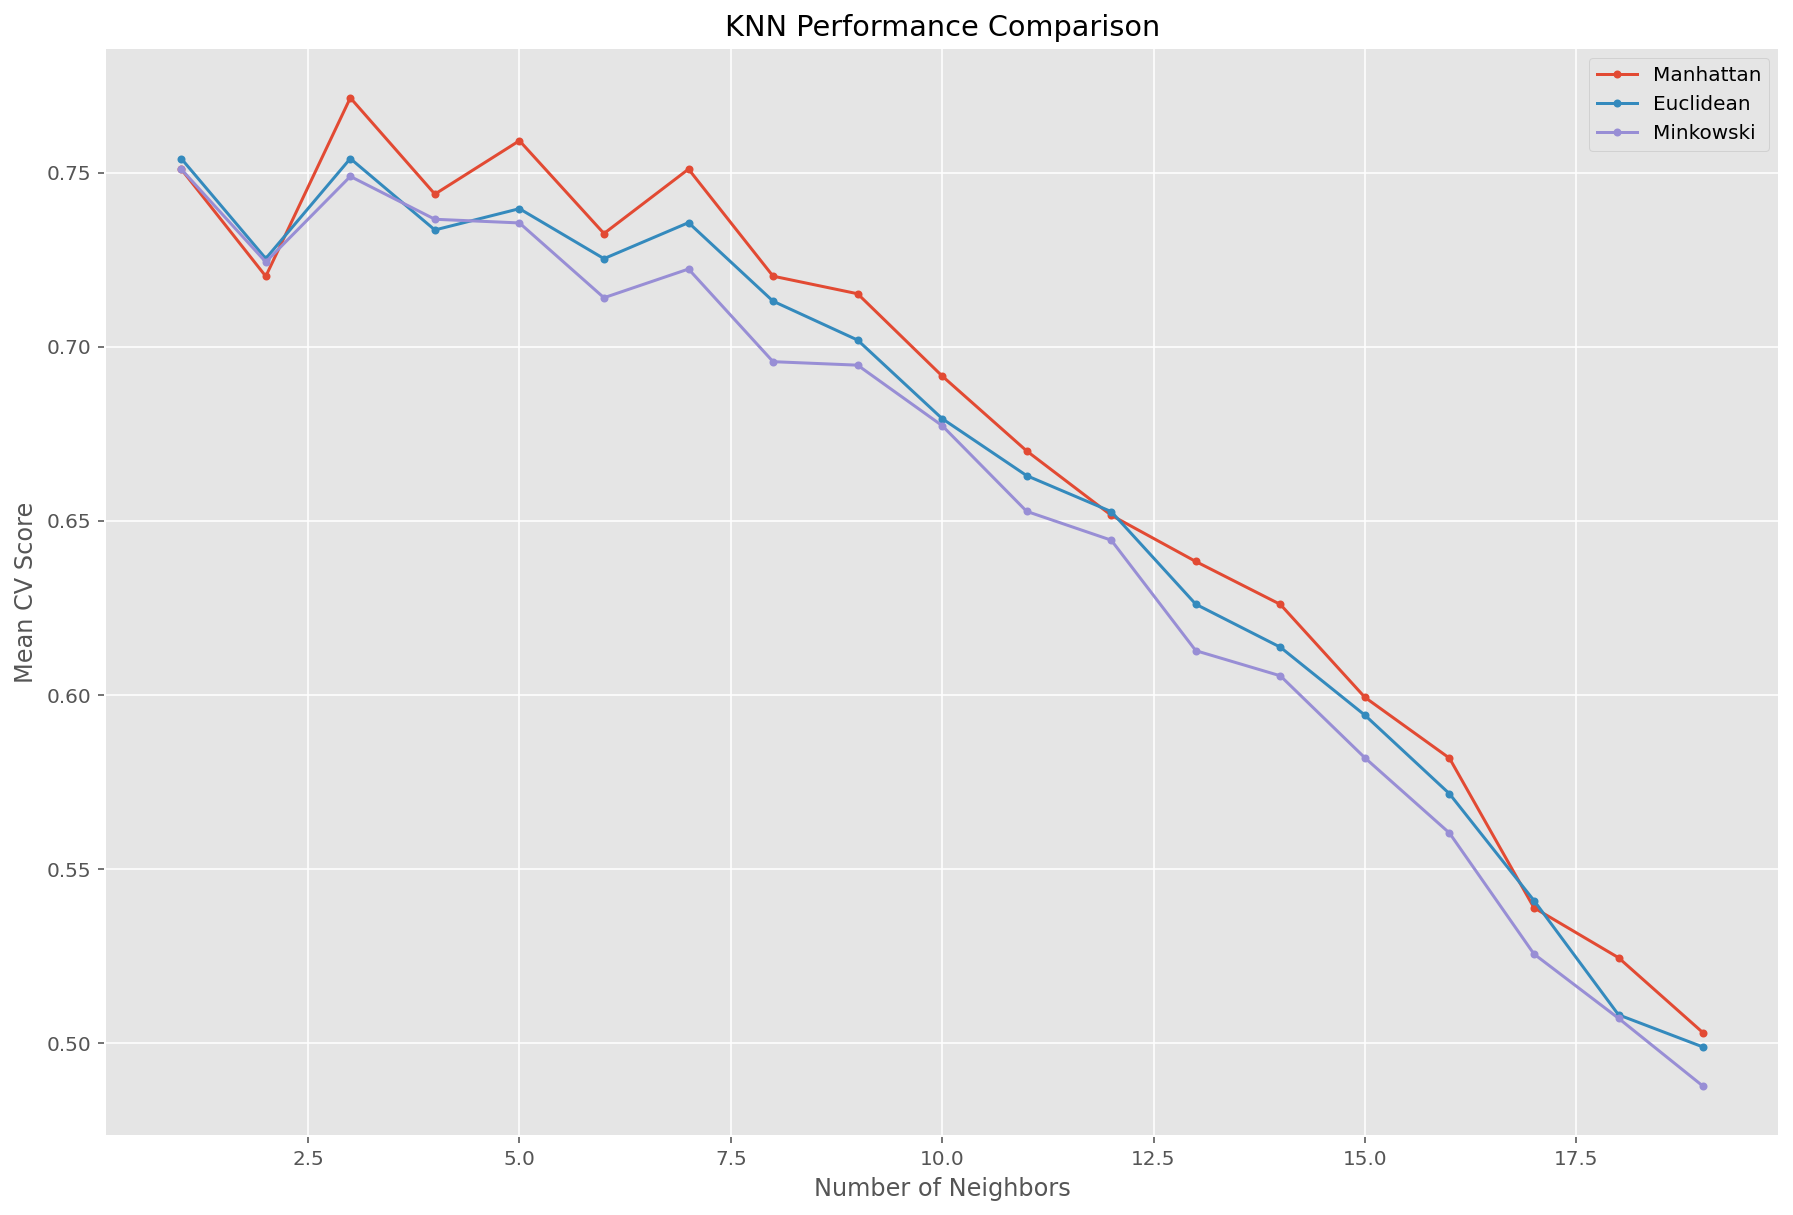

In [147]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

## Run on test data

In [148]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.70      0.71      0.71        84
    drummer5       0.90      0.82      0.86        45
    drummer7       0.81      0.86      0.84        59
    drummer8       0.73      0.70      0.71        57

    accuracy                           0.77       245
   macro avg       0.78      0.78      0.78       245
weighted avg       0.77      0.77      0.77       245



# kNN ensemble TODO, TRY THIS!!
* https://scikit-learn.org/stable/modules/ensemble.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [52]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Decision Tree

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://scikit-learn.org/stable/modules/tree.html

In [149]:
X_train.describe()
X_train_prepped = ct_v4.fit_transform(X_train)

tmp_df1 = pd.DataFrame(X_train_prepped)
tmp_df1.head()


,velocity,beat_offset,bar_beat_number
count,976.000000,976.000000,976.000000
mean,68.715164,-6.444672,8.689549
std,34.981502,14.840451,4.393577
min,5.000000,-57.000000,1.000000
25%,39.000000,-16.000000,5.000000
50%,63.000000,-6.000000,9.000000
75%,95.000000,4.000000,13.000000
max,127.000000,56.000000,16.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.506675,-0.104857,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.735484,0.906412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.667016,0.501904,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.951986,1.041248,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.551569,0.973830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#tree_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=4)


tree_clf.fit(X_train_prepped, y_train)
#tree.plot_tree(tree_clf) 


DecisionTreeClassifier(max_depth=4)

In [151]:
from sklearn import metrics
X_test_prepped = ct_v4.fit_transform(X_test)
y_pred = tree_clf.predict(X_test_prepped)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6244897959183674


## GridSearchCV, DT

In [152]:
tree_clf = DecisionTreeClassifier(random_state=999)
dt_depth = list(np.arange(1, 20))

# can try modelling with scaling & dummies using previous setup ColTransformers...
#dt_prep_pipe = Pipeline(steps=[('prep',ct_v4), ('tree_clf', tree_clf)])

# apparently no scaling or dummies needed for DT
# new one to just encode 'note', leave everything else untouched
dt_enc_pipe = Pipeline(steps=[ ('enc', ct_note_enc), ('tree_clf', tree_clf)])

# setup param grid...
dt_params = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

# choose from dt_enc_pipe or dt_prep_pipe
my_clf = dt_enc_pipe

gscv_dt = GridSearchCV(estimator=my_clf, 
                     param_grid=dt_params, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

gscv_dt.fit(X_train, y_train);

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.8s finished


In [153]:
gscv_dt.best_params_

{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 9,
 'tree_clf__min_samples_split': 2}

In [154]:
gscv_dt.best_score_

0.6773090679570798

In [155]:
results_DT = pd.DataFrame(gscv_dt.cv_results_['params'])
results_DT['test_score'] = gscv_dt.cv_results_['mean_test_score']
results_DT.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

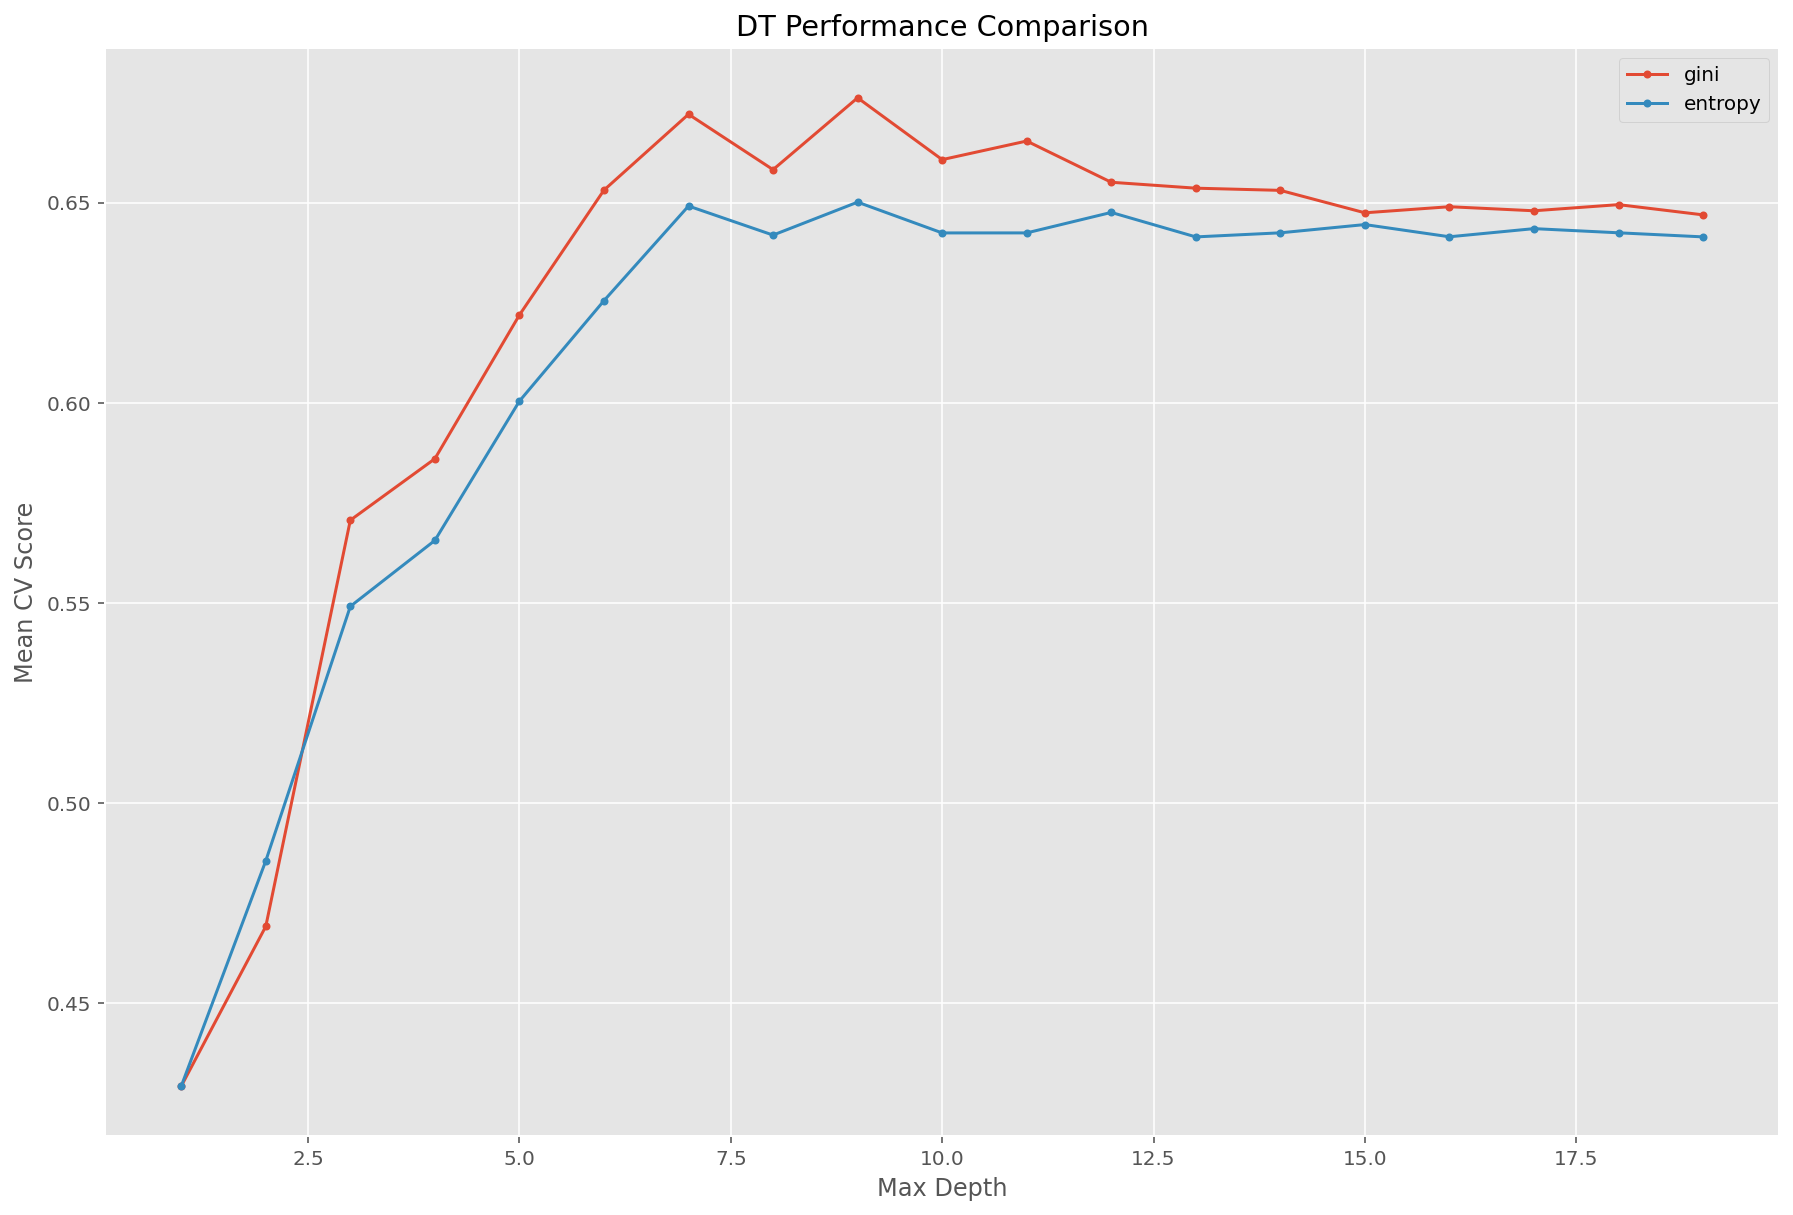

In [156]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['tree_clf__criterion'] == i]
    temp_average = temp.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## GridSearchCV, DT, manual loop

In [157]:
# list of ColumnTransformers setup previously
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_note_enc]
#col_trans = [ct_v4, ct_note_enc]

dt_depth = list(np.arange(1, 20))

dt_params_grid = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

overall_best_score = 0
overall_best_classifier2 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  dt_pipe = Pipeline(steps=[('prep',ct), ('tree_clf', DecisionTreeClassifier(random_state=999))])
  gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params_grid, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_dt.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_dt.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_dt.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_dt.best_params_)

  if gscv_dt.best_score_ > overall_best_score:
    overall_best_score = gscv_dt.best_score_
    overall_best_classifier2 = gscv_dt


_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   12.1s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=9, min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#0



0.6905638544077425


___BEST PARAMS, pipe#0



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 9,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   17.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=12, min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#1



0.7142015569114244


___BEST PARAMS, pipe#1



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 12,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   15.7s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=9, min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#2



0.6854512939196298


___BEST PARAMS, pipe#2



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 9,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   11.8s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=9, min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#3



0.6885230380812118


___BEST PARAMS, pipe#3



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 9,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   13.5s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=12, min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#4



0.7162528929097413


___BEST PARAMS, pipe#4



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 12,
 'tree_clf__min_samples_split': 3}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #5.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#5



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.8s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_label_enc',
                                                  OrdinalEncoder(), [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=9, random_state=999))])


___BEST SCORE, pipe#5



0.6773090679570798


___BEST PARAMS, pipe#5



{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 9,
 'tree_clf__min_samples_split': 2}

Overall ...

In [158]:
print('\n Overall .. BEST SCORE')
display(overall_best_classifier2.best_score_)

print('\n Overall .. BEST PARAMS')
display(overall_best_classifier2.best_params_)


 Overall .. BEST SCORE


0.7162528929097413


 Overall .. BEST PARAMS


{'tree_clf__criterion': 'gini',
 'tree_clf__max_depth': 12,
 'tree_clf__min_samples_split': 3}

## Chart results

In [159]:
dt_results = pd.DataFrame(overall_best_classifier2.cv_results_['params'])
dt_results['test_score'] = overall_best_classifier2.cv_results_['mean_test_score']
dt_results.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

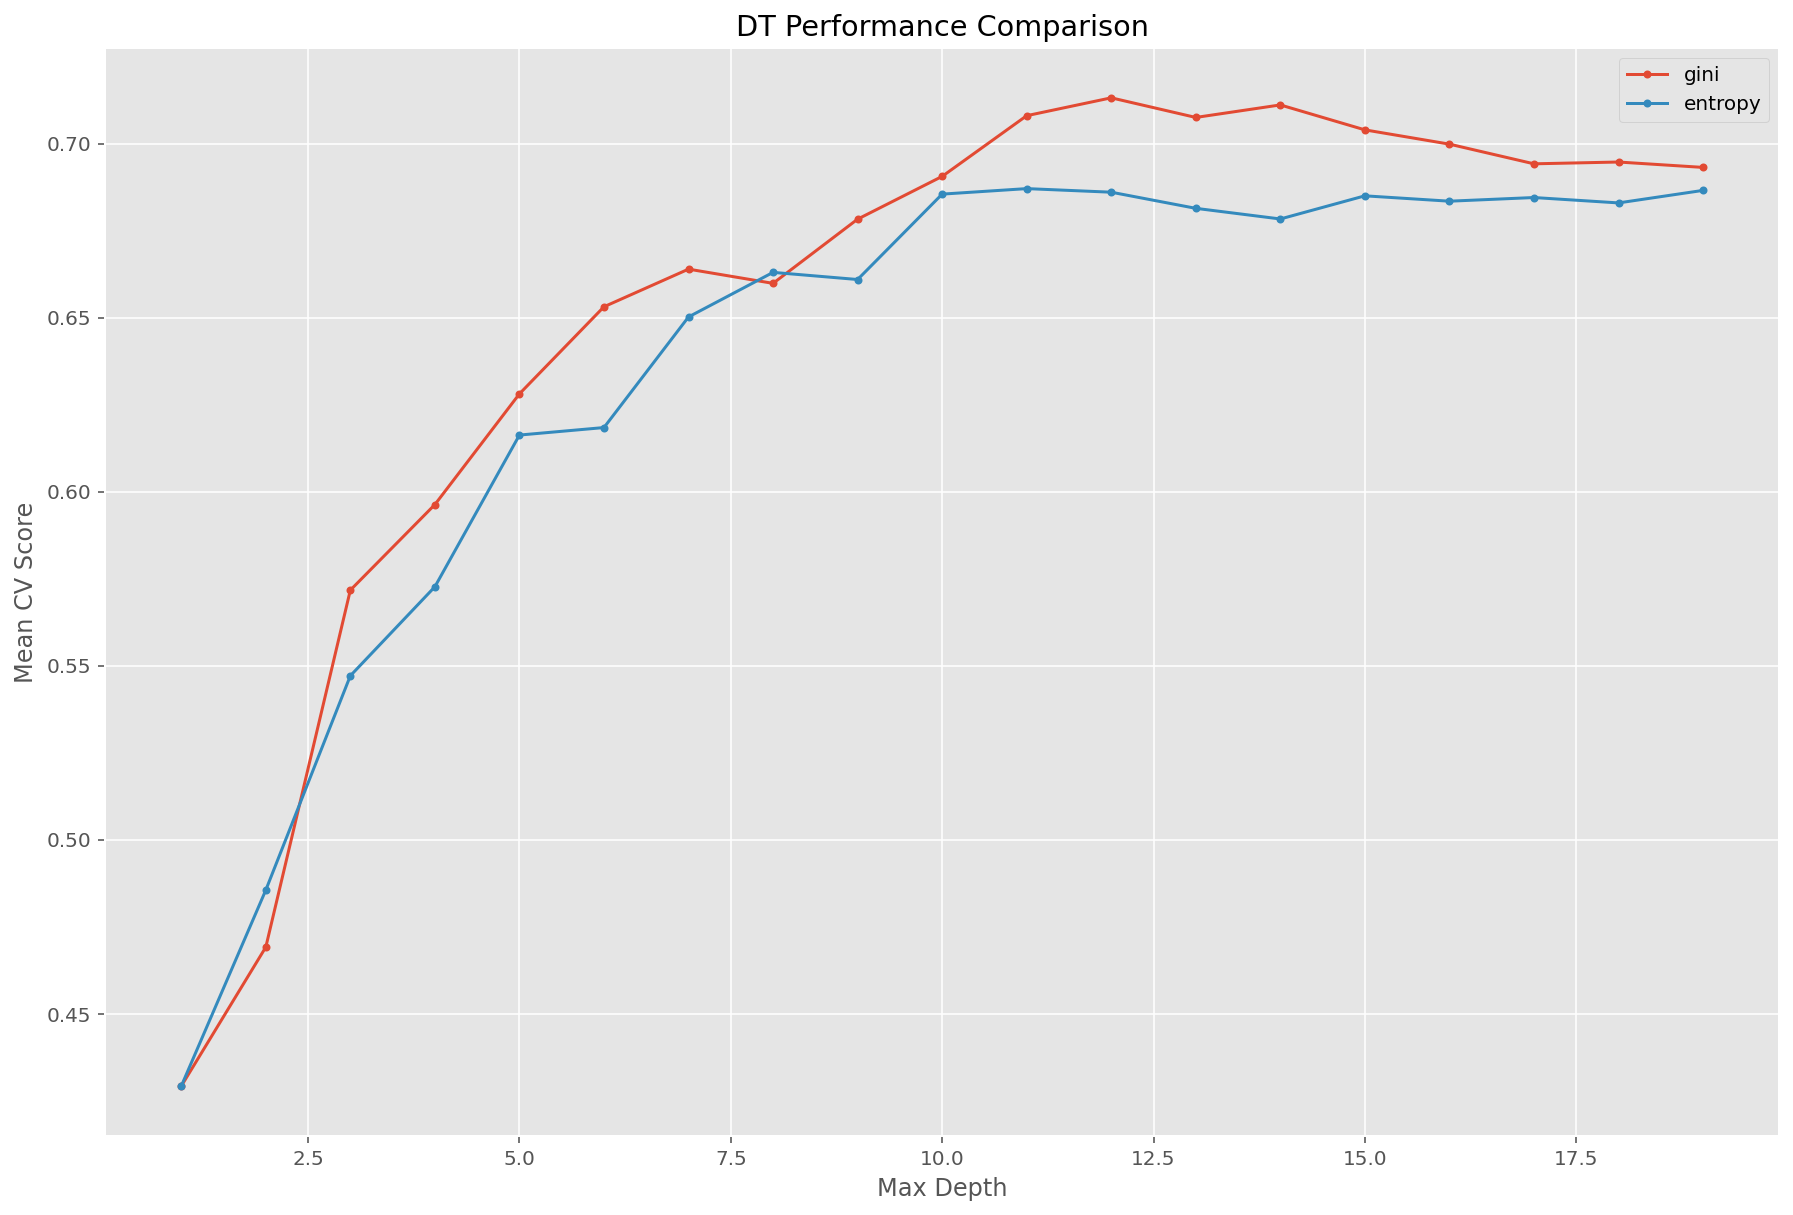

In [160]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ['gini', 'entropy']:
    tmp_crit = dt_results[dt_results['tree_clf__criterion'] == i]
    tmp_avg = tmp_crit.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(tmp_avg, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## Run on test data

In [161]:
y_pred = overall_best_classifier2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.64      0.69      0.66        84
    drummer5       0.82      0.69      0.75        45
    drummer7       0.79      0.64      0.71        59
    drummer8       0.68      0.81      0.74        57

    accuracy                           0.71       245
   macro avg       0.73      0.71      0.71       245
weighted avg       0.72      0.71      0.71       245



# SVM with RBF

* https://scikit-learn.org/stable/modules/svm.html#classification
* https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [66]:
from sklearn.svm import SVC

In [118]:
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.
#C_range = np.logspace(-2, 10, 13)
C_range = np.logspace(-2, 10, 3)
#gamma_range = np.logspace(-9, 3, 13)
gamma_range = np.logspace(-9, 3, 3)


In [119]:
print('C range: {}'.format(C_range))
print('Gamma range: {}'.format(gamma_range))

# list of ColumnTransformers setup previously
#col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
col_trans = [ct_v0]



svm_params_grid = {'svc_clf__gamma': gamma_range,
                  'svc_clf__C': C_range}

overall_best_score = 0
overall_best_classifier3 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  svm_pipe = Pipeline(steps=[('prep',ct), ('svc_clf', SVC(kernel='rbf'))])
  gscv_svm = GridSearchCV(estimator=svm_pipe, 
                     param_grid=svm_params_grid, 
                     cv=5,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_svm.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_svm.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_svm.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_svm.best_params_)

  if gscv_svm.best_score_ > overall_best_score:
    overall_best_score = gscv_svm.best_score_
    overall_best_classifier3 = gscv_svm

C range: [1.e-02 1.e+04 1.e+10]
Gamma range: [1.e-09 1.e-03 1.e+03]

_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.3min finished



___BEST ESTIMATOR, pipe#0



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])


___BEST SCORE, pipe#0



0.47759093619558735


___BEST PARAMS, pipe#0



{'svc_clf__C': 10000000000.0, 'svc_clf__gamma': 0.001}

# VotingClassifier

Review classifiers so far...

In [69]:
overall_best_classifier.best_estimator_
overall_best_classifier2.best_estimator_
overall_best_classifier3.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('knn', KNeighborsClassifier(n_neighbors=3, p=5))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=12, random_state=999))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])

Create a voting ensemble aggregate of all prior best classifiers...

In [70]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(estimators=[('knn', overall_best_classifier.best_estimator_), 
                                    ('dt', overall_best_classifier2.best_estimator_), 
                                    ('svm', overall_best_classifier3.best_estimator_), 
                                    ],voting='hard')

In [71]:
for clf, label in zip([overall_best_classifier.best_estimator_, 
                       overall_best_classifier2.best_estimator_, 
                       overall_best_classifier3.best_estimator_, 
                       eclf],
                      ['KNN', 'DT', 'SVM', 'Ensemble']):
  scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.69 (+/- 0.03) [KNN]
Accuracy: 0.62 (+/- 0.04) [DT]
Accuracy: 0.59 (+/- 0.02) [SVM]
Accuracy: 0.68 (+/- 0.04) [Ensemble]
